### Import necessary libraries

In [1]:
import signatory
import notebook_base

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline


from mean_variance.utils import *
from mean_variance.simulators import *
from mean_variance.sig_trader import *
from data.path import Path

In [2]:
plt.rcParams.update(plt.rcParamsDefault)

In [3]:
if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

device: cpu


### Genetate Paths for training and testing

In [4]:
torch.manual_seed(8)

N = 1000

paths = generate_OU_paths(
    n_samples=2*N,
    n_days=200,
    dt=1, 
    dim=1, 
    S_0=0,
    theta=0.01,
    sigma=0.03, 
    mu=0)+1

train_paths = paths[:N]
test_paths = paths[N:]

In [5]:
paths_bm = generate_gbm(n_samples = 2*N, n_days = 199, mu = 0, vol = 0.01, dt = 1, dim = 1)
train_paths_bm = paths_bm[:N]
test_paths_bm = paths_bm[N:]

### Construct the porfolio of 2 assets

In [6]:
multidim_paths = torch.cat((train_paths,train_paths_bm), dim=-1)

In [7]:
multidim_paths_test = torch.cat((test_paths,test_paths_bm), dim=-1)

### Visualize train paths

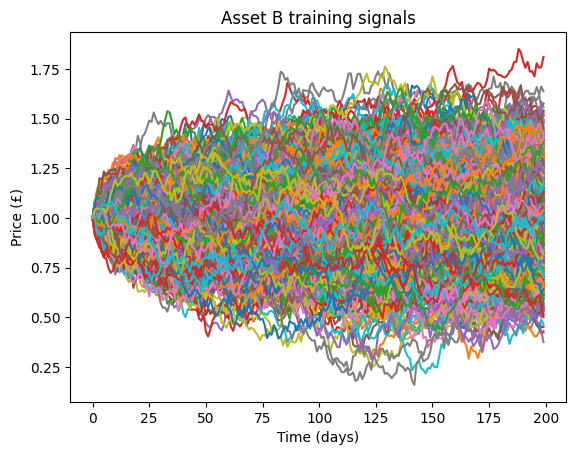

In [8]:
plt.plot(multidim_paths[:,:,0].T)
plt.title('Asset B training signals')
plt.xlabel('Time (days)')
plt.ylabel('Price (£)')
plt.savefig('asset2_training.png', dpi=300)
plt.show()

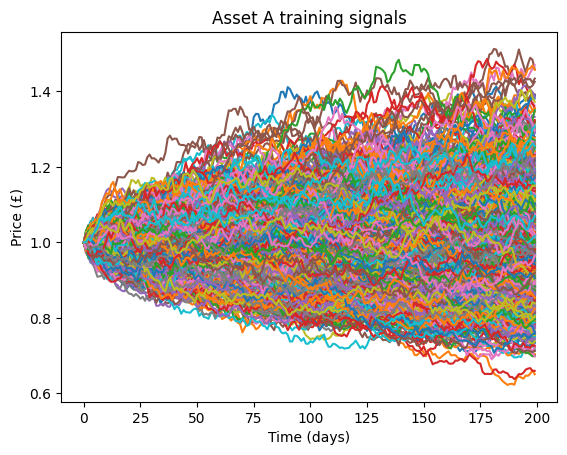

In [9]:
plt.plot(multidim_paths[:,:,1].T)
plt.title('Asset A training signals')
plt.xlabel('Time (days)')
plt.ylabel('Price (£)')
plt.savefig('asset1_training.png', dpi=300)
plt.show()

### Train and fit model

In [10]:
order = 3
ST = SigTrader(order=order)

In [11]:
ST.fit(asset_paths = multidim_paths, order=order, fast_sol=True, max_var=0.05);

In [12]:
position, pnl = ST.compute_pnl(asset_paths = multidim_paths_test)
sample_pos, sample_pnl = ST.compute_pnl(asset_paths = multidim_paths, order = order)

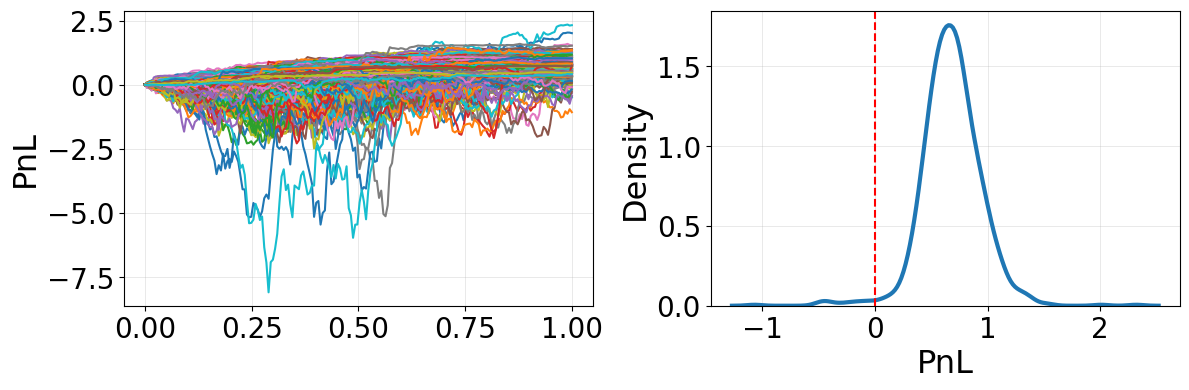

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(np.linspace(0,1,pnl.shape[-1]), pnl.T);
ax[0].set_ylabel('PnL')

sns.kdeplot(pnl[:,-1], label='PnL distribution',ax = ax[1], lw=3)
ax[1].axvline(0, color='r', linestyle='--', label='Zero PnL')
ax[1].set_xlabel('PnL')

for i in range(2):
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()
plt.show()

### Example of how the model trades for one test path

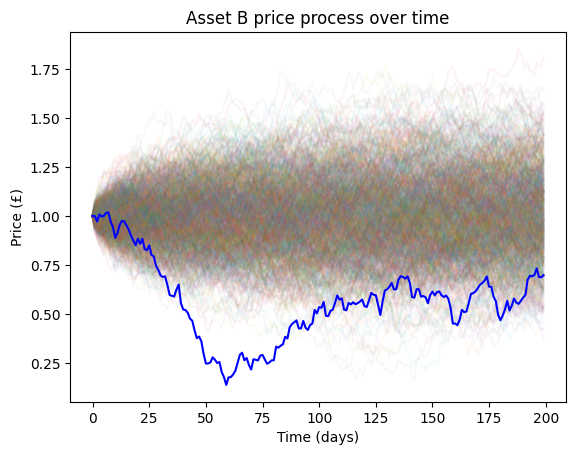

In [14]:
plt.plot(train_paths[:,:,0].T,alpha = 0.05)
plt.plot(test_paths[709],color = 'blue')
plt.title('Asset B price process over time')
plt.xlabel('Time (days)')
plt.ylabel('Price (£)')
plt.savefig('asset2_price_process.png', dpi=300)
plt.show()

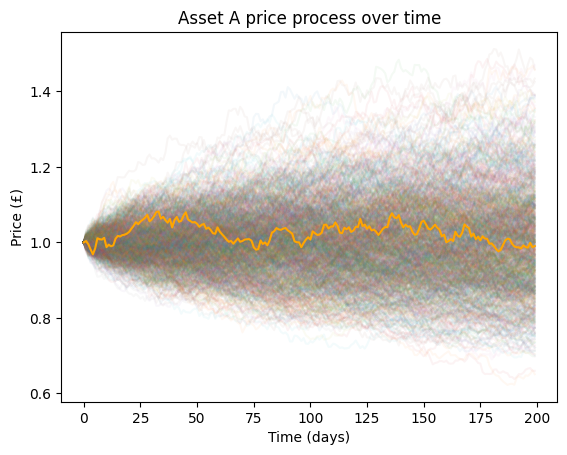

In [15]:
plt.plot(train_paths_bm[:,:,0].T,alpha = 0.05)
plt.plot(test_paths_bm[709],color = 'orange')
plt.title('Asset A price process over time')
plt.xlabel('Time (days)')
plt.ylabel('Price (£)')
plt.savefig('asset1_price_process.png', dpi=300)
plt.show()

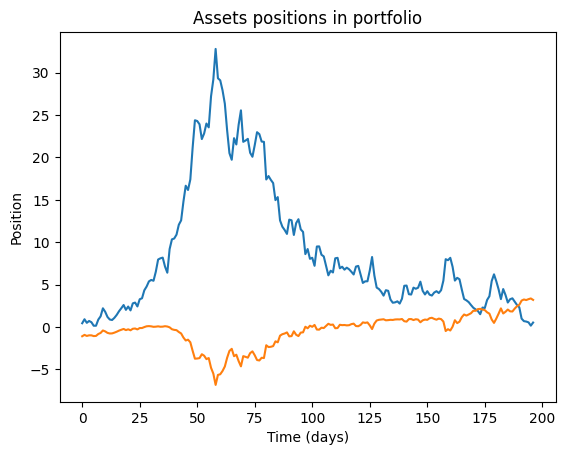

In [16]:
plt.plot(position[709])
plt.title('Assets positions in portfolio')
plt.xlabel('Time (days)')
plt.ylabel('Position')
plt.savefig('portfolio_positions.png', dpi=300)
plt.show()

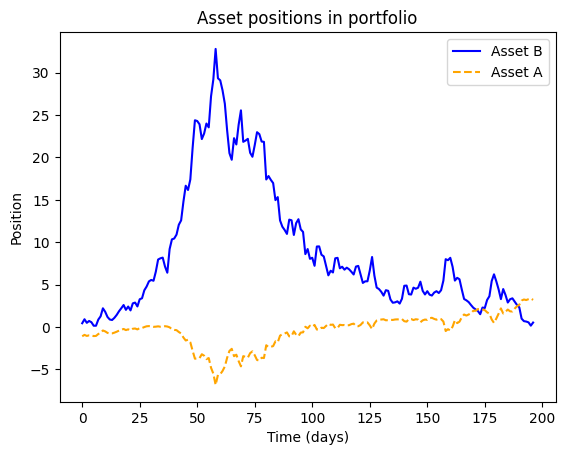

In [17]:
line1 = position[709][:,0]
line2 = position[709][:,1]

# Plot each line with a specific label
plt.plot(line1, label='Asset B', color='blue')
plt.plot(line2, label='Asset A', color='orange',linestyle='--')

# Add title and labels
plt.title('Asset positions in portfolio')
plt.xlabel('Time (days)')
plt.ylabel('Position')

# Add legend
plt.legend()

# Save and show the plot
plt.savefig('portfolio_positions.png', dpi=300)
plt.show()

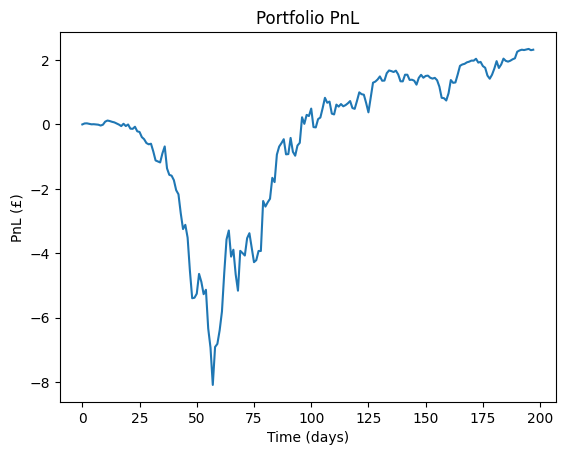

In [18]:
plt.plot(pnl[709])
plt.title('Portfolio PnL')
plt.xlabel('Time (days)')
plt.ylabel('PnL (£)')
plt.savefig('portfolio_pnl.png', dpi=300)
plt.show()

### Comparison of theoretical and realized $\mathbb{E}[V_T]$ and $\text{Var}[V_T]$

In [19]:
# Terminal Expectation (Theoretical)
ST_mu = (ST.l @ ST.mu_sig).item()
print(f"Terminal Expectation (Theoretical): {ST_mu:.4f}")

# Terminal Expectation (Realized)
pnl_mu = sample_pnl[:, -1].mean()
print(f"Terminal Expectation (Realized): {pnl_mu:.4f}")

Terminal Expectation (Theoretical): 0.6733
Terminal Expectation (Realized): 0.6723


In [20]:
# Terminal Variance (Theoretical)
ST_var = (((ST.l) @ ST.var_sig)[-1] @ ST.l.T).item()
print(f"Terminal Variance (Theoretical): {ST_var:.4f}")

# Terminal Variance (Realized)
pnl_var = sample_pnl[:,-1].var(unbiased=False).item()
print(f"Terminal Variance (Realized): {pnl_var:.4f}")

Terminal Variance (Theoretical): 0.0500
Terminal Variance (Realized): 0.0498


# Out-of-Sample Performance Tests

## Test 1: Performance with respect to training size

### Define the training sizes we test on

In [21]:
train_sizes = np.logspace(1, 4, num=50, dtype=int)

### Generate test paths

In [22]:
torch.manual_seed(88)
testing_paths = generate_OU_paths(
        n_samples=1000,
        n_days=200,
        dt=1, 
        dim=1, 
        S_0=1,
        theta=0.01,
        sigma=0.03, 
        mu=0)

### Run Monte Carlo simulations for both classic and robust methods for all training sizes

In [23]:
torch.manual_seed(6759)
risk_aversion = 0.1
normal_list = []
robust_list = []
normal_list2 = []
robust_list2 = []

for t in train_sizes:
    normal_difference = []
    robust_difference = []
    normal_difference2 = []
    robust_difference2 = []

    for i in range(50):
        curr_paths = generate_OU_paths(
        n_samples=t,
        n_days=200,
        dt=1, 
        dim=1, 
        S_0=1,
        theta=0.01,
        sigma=0.03, 
        mu=0)
        
        order = 2
        ST = SigTrader(order=order)
        ST.fit(asset_paths = curr_paths, order=order, fast_sol=True, max_var=0.05)
        position, pnl = ST.compute_pnl(asset_paths = testing_paths)
        sample_pos, sample_pnl = ST.compute_pnl(asset_paths = curr_paths, order = order)
        
        
        
        ST_robust = SigTrader(order=order)
        ST_robust.fit(asset_paths = curr_paths, order=order, fast_sol=True, max_var=0.05)
        ST_robust.strategy.var_sig = ST_robust.var_sig + risk_aversion*torch.eye(ST_robust.var_sig.shape[-1])
        l = (torch.inverse(ST_robust.strategy.var_sig) @ ST_robust.strategy.mu_sig).T 
        normalization = (l[0] @ ST_robust.strategy.var_sig @ l[0] / 0.05).sqrt()
        l = l / normalization
        ST_robust.strategy.l = l
        robust_position, robust_pnl = ST_robust.compute_pnl(asset_paths = testing_paths)
        robust_sample_pos, robust_sample_pnl = ST_robust.compute_pnl(asset_paths = curr_paths, order = order)
        
        
        normal_diff = ((abs(sample_pnl[:,-1].mean() - pnl[:,-1].mean()))/(sample_pnl[:,-1].mean())) * 100
        robust_diff = ((abs(robust_sample_pnl[:,-1].mean() - robust_pnl[:,-1].mean()))/(robust_sample_pnl[:,-1].mean())) * 100
        normal_diff2 = (abs(sample_pnl[:,-1].mean() - pnl[:,-1].mean()))
        robust_diff2 = (abs(robust_sample_pnl[:,-1].mean() - robust_pnl[:,-1].mean()))

        normal_difference.append(normal_diff)
        robust_difference.append(robust_diff)
        normal_difference2.append(normal_diff2)
        robust_difference2.append(robust_diff2)
    
    
    a = np.mean(normal_difference)
    b = np.mean(robust_difference)
    c = np.mean(normal_difference2)
    d = np.mean(robust_difference2)

    
    normal_list.append(a)
    robust_list.append(b)
    normal_list2.append(c)
    robust_list2.append(d)

### Plot lines to visualize the consistency between training and testing $\mathbb{E}[V_T]$ for both methods

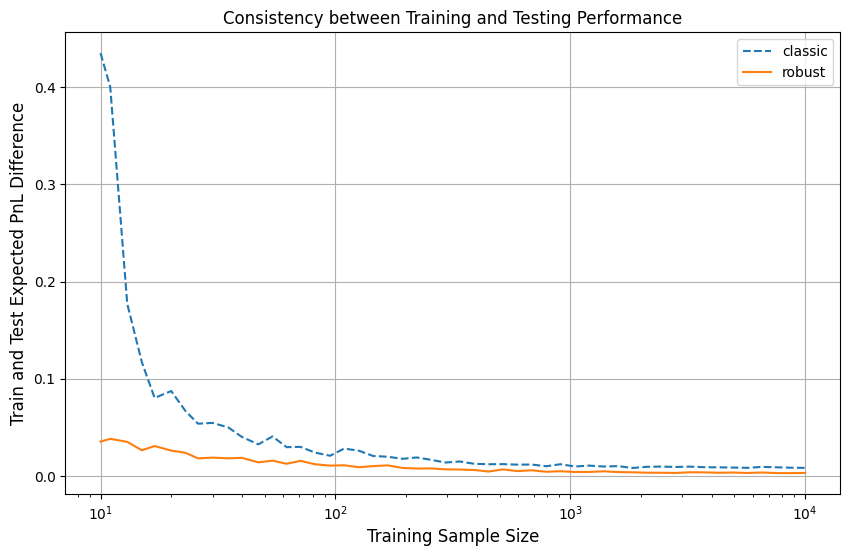

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, normal_list2, label='classic',linestyle = '--')
plt.plot(train_sizes, robust_list2, label='robust')
plt.xscale('log')
plt.xlabel('Training Sample Size',fontsize=12)
plt.ylabel('Train and Test Expected PnL Difference',fontsize=12)
plt.title('Consistency between Training and Testing Performance',fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('train_sizes.png', dpi=300)
plt.show()


### Performing the same test with different test paths

In [25]:
torch.manual_seed(88)
testing_paths23 = generate_OU_paths(
        n_samples=1000,
        n_days=200,
        dt=1, 
        dim=1, 
        S_0=1,
        theta=0.001,
        sigma=0.03, 
        mu=0)

In [26]:
torch.manual_seed(6759)
risk_aversion = 0.1
normal_list = []
robust_list = []
normal_list2 = []
robust_list2 = []

for t in train_sizes:
    normal_difference = []
    robust_difference = []
    normal_difference2 = []
    robust_difference2 = []

    for i in range(50):
        curr_paths = generate_OU_paths(
        n_samples=t,
        n_days=200,
        dt=1, 
        dim=1, 
        S_0=1,
        theta=0.01,
        sigma=0.03, 
        mu=0)
        
        order = 2
        ST = SigTrader(order=order)
        ST.fit(asset_paths = curr_paths, order=order, fast_sol=True, max_var=0.05)
        position, pnl = ST.compute_pnl(asset_paths = testing_paths23)
        sample_pos, sample_pnl = ST.compute_pnl(asset_paths = curr_paths, order = order)
        
        
        
        ST_robust = SigTrader(order=order)
        ST_robust.fit(asset_paths = curr_paths, order=order, fast_sol=True, max_var=0.05)
        ST_robust.strategy.var_sig = ST_robust.var_sig + risk_aversion*torch.eye(ST_robust.var_sig.shape[-1])
        l = (torch.inverse(ST_robust.strategy.var_sig) @ ST_robust.strategy.mu_sig).T 
        normalization = (l[0] @ ST_robust.strategy.var_sig @ l[0] / 0.05).sqrt()
        l = l / normalization
        ST_robust.strategy.l = l
        robust_position, robust_pnl = ST_robust.compute_pnl(asset_paths = testing_paths23)
        robust_sample_pos, robust_sample_pnl = ST_robust.compute_pnl(asset_paths = curr_paths, order = order)
        
        
        normal_diff = ((abs(sample_pnl[:,-1].mean() - pnl[:,-1].mean()))/(sample_pnl[:,-1].mean())) * 100
        robust_diff = ((abs(robust_sample_pnl[:,-1].mean() - robust_pnl[:,-1].mean()))/(robust_sample_pnl[:,-1].mean())) * 100
        normal_diff2 = (abs(sample_pnl[:,-1].mean() - pnl[:,-1].mean()))
        robust_diff2 = (abs(robust_sample_pnl[:,-1].mean() - robust_pnl[:,-1].mean()))

        normal_difference.append(normal_diff)
        robust_difference.append(robust_diff)
        normal_difference2.append(normal_diff2)
        robust_difference2.append(robust_diff2)
    
    
    a = np.mean(normal_difference)
    b = np.mean(robust_difference)
    c = np.mean(normal_difference2)
    d = np.mean(robust_difference2)

    
    normal_list.append(a)
    robust_list.append(b)
    normal_list2.append(c)
    robust_list2.append(d)

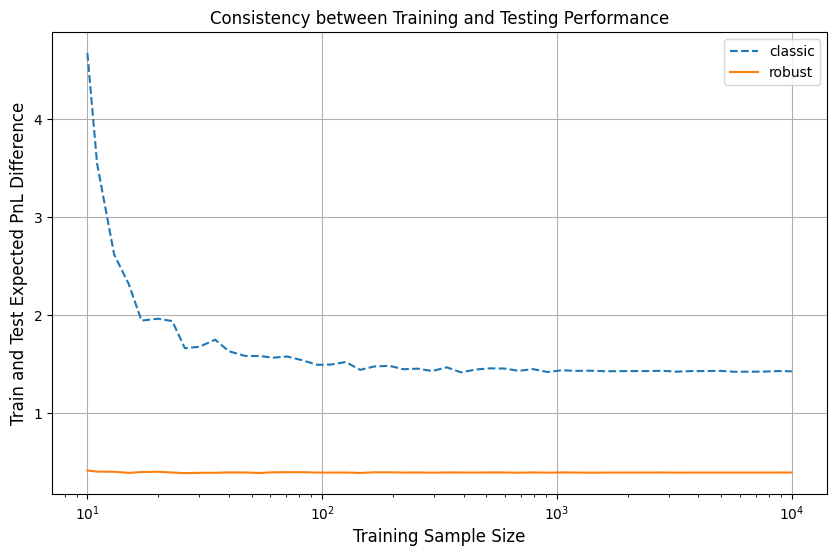

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, normal_list2, label='classic',linestyle = '--')
plt.plot(train_sizes, robust_list2, label='robust')
plt.xscale('log')
plt.xlabel('Training Sample Size',fontsize=12)
plt.ylabel('Train and Test Expected PnL Difference',fontsize=12)
plt.title('Consistency between Training and Testing Performance',fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('train_sizes_2.png', dpi=300)
plt.show()


## Test 2: Out-of-Sample Performance for varying test paths

### Generate train paths

In [28]:
torch.manual_seed(11654)
training_path2 = generate_OU_paths(
        n_samples=1000,
        n_days=200,
        dt=1, 
        dim=1, 
        S_0=1,
        theta=0.01,
        sigma=0.03, 
        mu=0)

### Train both models

In [29]:
order = 2

ST = SigTrader(order=order)
ST.fit(asset_paths = training_path2, order=order, fast_sol=True, max_var=0.05)


ST_robust = SigTrader(order=order)
ST_robust.fit(asset_paths = training_path2, order=order, fast_sol=True, max_var=0.05)

risk_aversion = 0.02
ST_robust.strategy.var_sig = ST_robust.var_sig + risk_aversion*torch.eye(ST_robust.var_sig.shape[-1])
l = (torch.inverse(ST_robust.strategy.var_sig) @ ST_robust.strategy.mu_sig).T 
normalization = (l[0] @ ST_robust.strategy.var_sig @ l[0] / 0.05).sqrt()
l = l / normalization
ST_robust.strategy.l = l

robust_l = ST_robust.strategy.l
orig_l = ST.l

### Sanity check that linear functionals of two models are different

In [30]:
robust_l == orig_l

tensor([[False, False, False, False, False, False, False]])

### Defining the test data parameters we will be changing

In [31]:
# This is just a sample case. the parameters used in the dissertation differ from the ones used here.
sigmas = np.linspace(0.01,0.5, 100)
thetas = np.linspace(0,0.1, 100)

In [32]:
perfs = np.zeros((len(sigmas), len(thetas)))
robust_perfs = np.zeros((len(sigmas), len(thetas)))

perfs_position = np.zeros((len(sigmas), len(thetas)))
robust_perfs_position = np.zeros((len(sigmas), len(thetas)))

### Simulations 

In [33]:
torch.manual_seed(717)
for i, sigma in enumerate(sigmas):
    for j, theta in enumerate(thetas):
        
        test_paths_2 = generate_OU_paths(
        n_samples=1000,
        n_days=200,
        dt=1, 
        dim=1, 
        S_0=1,
        theta=theta,
        sigma=sigma, 
        mu=0)
        
        _ , test_pnl = ST.compute_pnl(asset_paths = test_paths_2, order = order, lin_func = orig_l)
        _ , robust_test_pnl = ST_robust.compute_pnl(asset_paths = test_paths_2, order = order, lin_func = robust_l)
        
        perfs[i,j] = test_pnl[:,-1].mean()/test_pnl[:,-1].std()
        robust_perfs[i,j] = robust_test_pnl[:,-1].mean()/robust_test_pnl[:,-1].std()
        

### Heatmap plots for classic and robust methods

/var/folders/2v/8k8s0q0d1v35vwv2rnmrh6t40000gn/T/ipykernel_81890/4191975005.py:1: RuntimeWarning: invalid value encountered in log
  im = plt.imshow(np.log(perfs).T, origin='lower', aspect='auto', cmap='magma',
/var/folders/2v/8k8s0q0d1v35vwv2rnmrh6t40000gn/T/ipykernel_81890/4191975005.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1200x400 with 2 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, pad=0.05)


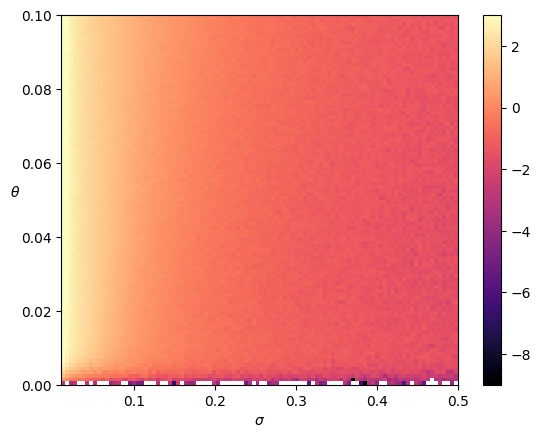

In [34]:
im = plt.imshow(np.log(perfs).T, origin='lower', aspect='auto', cmap='magma',
            extent=[sigmas[0], sigmas[-1], thetas[0], thetas[-1]],vmin = -9 ,vmax = 3)
plt.xlabel(r'$\sigma$',fontsize = 10)
plt.ylabel(r'$\theta$',rotation=0,fontsize = 10)
cbar = fig.colorbar(im, pad=0.05)
plt.savefig('heatmap_classic_method', dpi=300)

/var/folders/2v/8k8s0q0d1v35vwv2rnmrh6t40000gn/T/ipykernel_81890/1771070447.py:1: RuntimeWarning: invalid value encountered in log
  im = plt.imshow(np.log(robust_perfs).T, origin='lower', aspect='auto', cmap='magma',
/var/folders/2v/8k8s0q0d1v35vwv2rnmrh6t40000gn/T/ipykernel_81890/1771070447.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1200x400 with 2 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, pad=0.02)


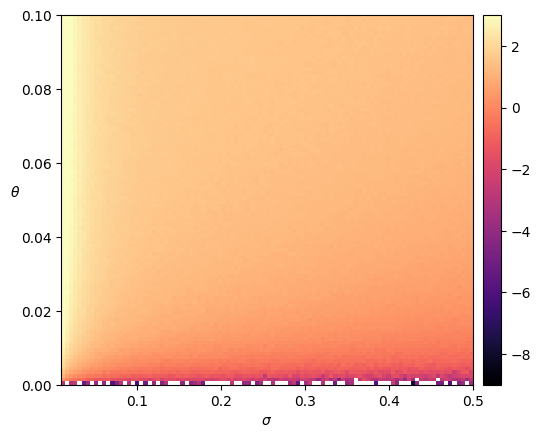

In [35]:
im = plt.imshow(np.log(robust_perfs).T, origin='lower', aspect='auto', cmap='magma',
            extent=[sigmas[0], sigmas[-1], thetas[0], thetas[-1]],vmin = -9 ,vmax = 3)
plt.xlabel(r'$\sigma$',fontsize=10)
plt.ylabel(r'$\theta$',rotation=0,fontsize=10)
cbar = fig.colorbar(im, pad=0.02)
plt.savefig('heatmap_robust_method', dpi=300)

### 2-D plots of $\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$ with respect to $\theta$

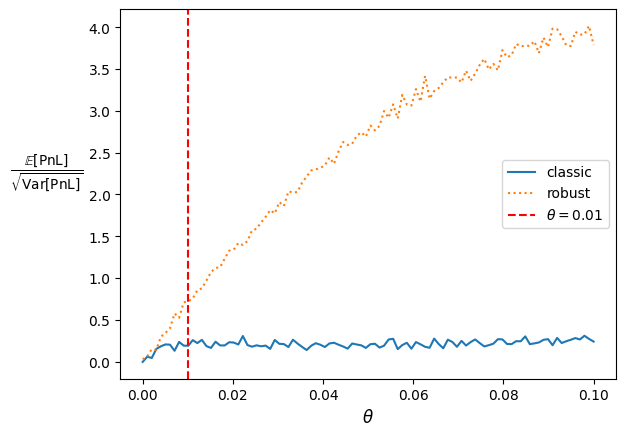

In [36]:
plt.plot(thetas, perfs[-1,:],label = 'classic') # max sigma 0.5
plt.plot(thetas, robust_perfs[-1,:], label = 'robust',linestyle = 'dotted')
plt.axvline(x=0.01, color='red', linestyle='--', label=r'$\theta = 0.01$')
plt.xlabel(r'$\theta$',fontsize=12, rotation=0)
plt.ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$',fontsize=14, rotation=0, labelpad=30)
plt.legend()
plt.savefig('thetas_max_sigma.png', dpi=300)

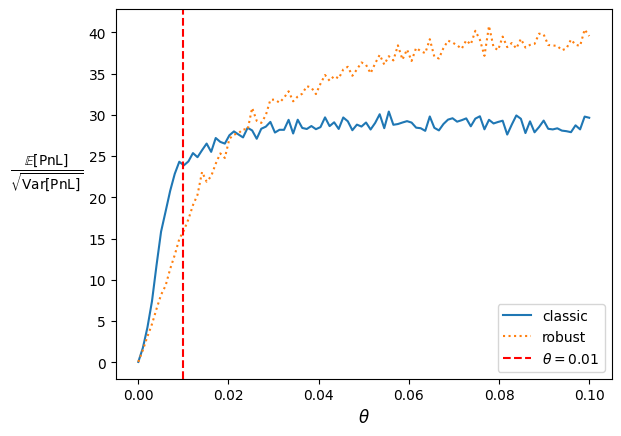

In [37]:
plt.plot(thetas, perfs[0,:],label = 'classic') # min sigma 0.01
plt.plot(thetas, robust_perfs[0,:], label = 'robust',linestyle = 'dotted')
plt.axvline(x=0.01, color='red', linestyle='--', label=r'$\theta = 0.01$')
plt.xlabel(r'$\theta$',fontsize=12, rotation=0)
plt.ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$',fontsize=14, rotation=0, labelpad=30)
plt.legend()
plt.savefig('thetas_min_sigma.png', dpi=300)

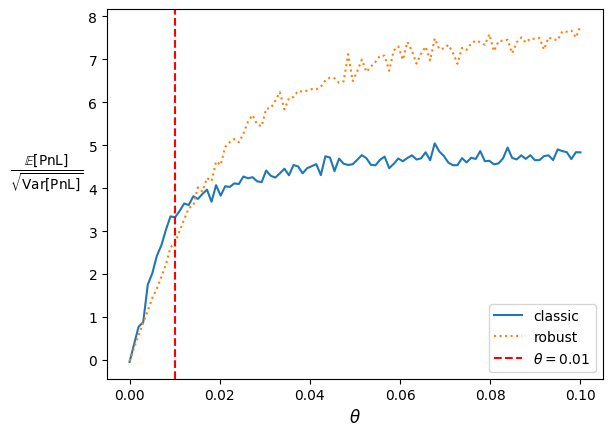

In [38]:
plt.plot(thetas, perfs[11,:],label = 'classic') # training sigma 0.03
plt.plot(thetas, robust_perfs[11,:], label = 'robust',linestyle = 'dotted')
plt.axvline(x=0.01, color='red', linestyle='--', label=r'$\theta = 0.01$')
plt.xlabel(r'$\theta$',fontsize=12, rotation=0)
plt.ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$',fontsize=14, rotation=0, labelpad=30)
plt.legend()
plt.savefig('thetas_train_sigma.png', dpi=300)

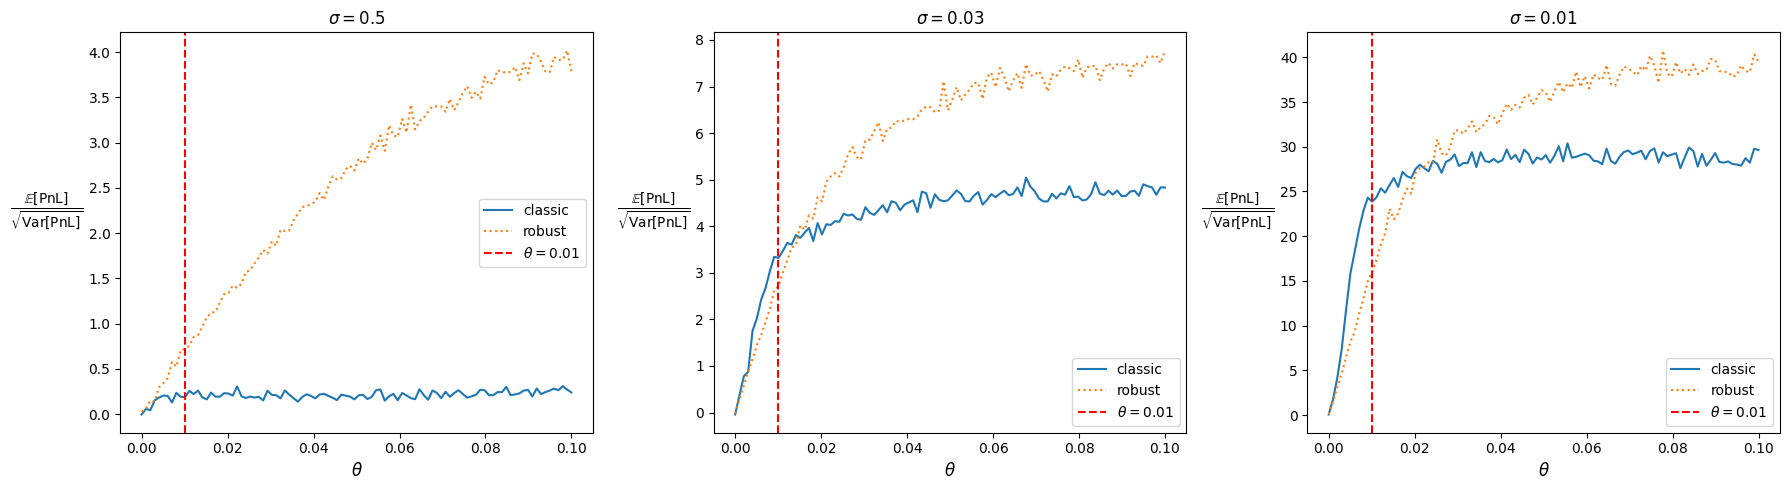

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: max sigma 0.5
axs[0].plot(thetas, perfs[-1], label='classic') # max sigma 0.5
axs[0].plot(thetas, robust_perfs[-1], label='robust', linestyle='dotted')
axs[0].axvline(x=0.01, color='red', linestyle='--', label=r'$\theta = 0.01$')
axs[0].set_xlabel(r'$\theta$', fontsize=12, rotation=0)
axs[0].set_ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$', fontsize=14, rotation=0, labelpad=30)
axs[0].legend()
axs[0].set_title(r'$\sigma = 0.5$')

# Plot 2: min sigma 0.01
axs[2].plot(thetas, perfs[0], label='classic') # min sigma 0.01
axs[2].plot(thetas, robust_perfs[0], label='robust', linestyle='dotted')
axs[2].axvline(x=0.01, color='red', linestyle='--', label=r'$\theta = 0.01$')
axs[2].set_xlabel(r'$\theta$', fontsize=12, rotation=0)
axs[2].set_ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$', fontsize=14, rotation=0, labelpad=30)
axs[2].legend()
axs[2].set_title(r'$\sigma = 0.01$')

# Plot 3: training sigma 0.03
axs[1].plot(thetas, perfs[11], label='classic') # training sigma 0.03
axs[1].plot(thetas, robust_perfs[11], label='robust', linestyle='dotted')
axs[1].axvline(x=0.01, color='red', linestyle='--', label=r'$\theta = 0.01$')
axs[1].set_xlabel(r'$\theta$', fontsize=12, rotation=0)
axs[1].set_ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$', fontsize=14, rotation=0, labelpad=30)
axs[1].legend()
axs[1].set_title(r'$\sigma = 0.03$')


plt.tight_layout()

plt.savefig('thetas_combined.png', dpi=300)

plt.show()


### 2-D plot of $\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$ with respect to $\sigma$

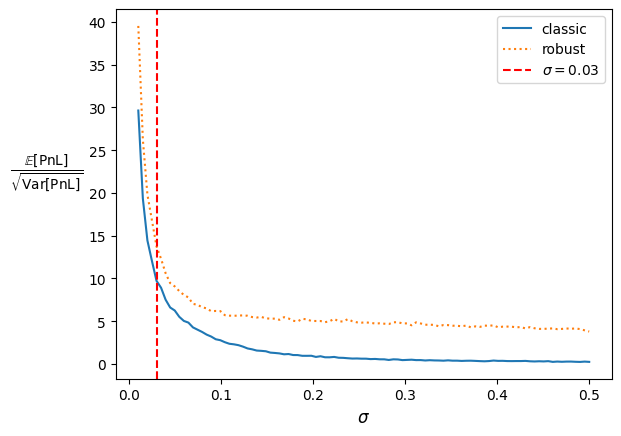

In [40]:
plt.plot(sigmas, perfs[:,-1], label = 'classic') # max theta 0.1
plt.plot(sigmas, robust_perfs[:,-1], label = 'robust',linestyle = 'dotted')
plt.axvline(x=0.03, color='red', linestyle='--', label=r'$\sigma = 0.03$')
plt.xlabel(r'$\sigma$',fontsize=12, rotation=0)
plt.ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$',fontsize=14, rotation=0, labelpad=30)
plt.legend()

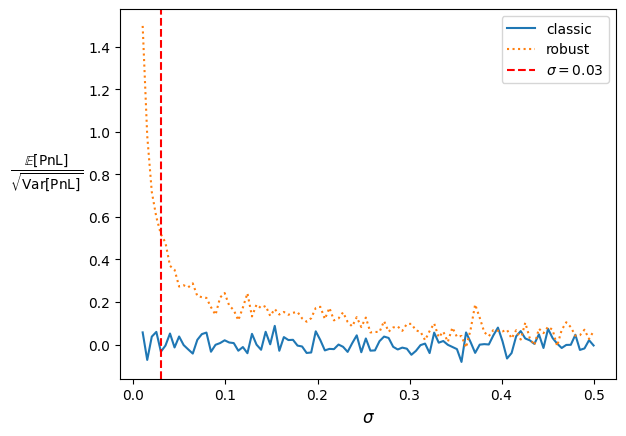

In [41]:
plt.plot(sigmas, perfs[:,0], label = 'classic') # theta = 0, i.e. GBM
plt.plot(sigmas, robust_perfs[:,1], label = 'robust',linestyle = 'dotted')
plt.axvline(x=0.03, color='red', linestyle='--', label=r'$\sigma = 0.03$')
plt.xlabel(r'$\sigma$',fontsize=12, rotation=0)
plt.ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$',fontsize=14, rotation=0, labelpad=30)
plt.legend()

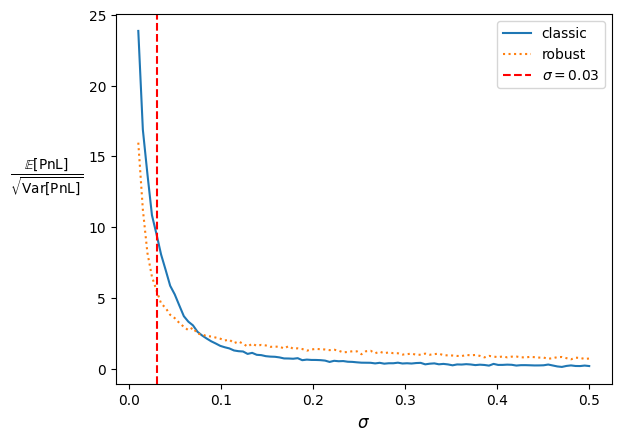

In [42]:
plt.plot(sigmas, perfs[:,10], label = 'classic') # training theta 0.01
plt.plot(sigmas, robust_perfs[:,10], label = 'robust',linestyle = 'dotted')
plt.axvline(x=0.03, color='red', linestyle='--', label=r'$\sigma = 0.03$')
plt.xlabel(r'$\sigma$',fontsize=12, rotation=0)
plt.ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$',fontsize=14, rotation=0, labelpad=30)
plt.legend()

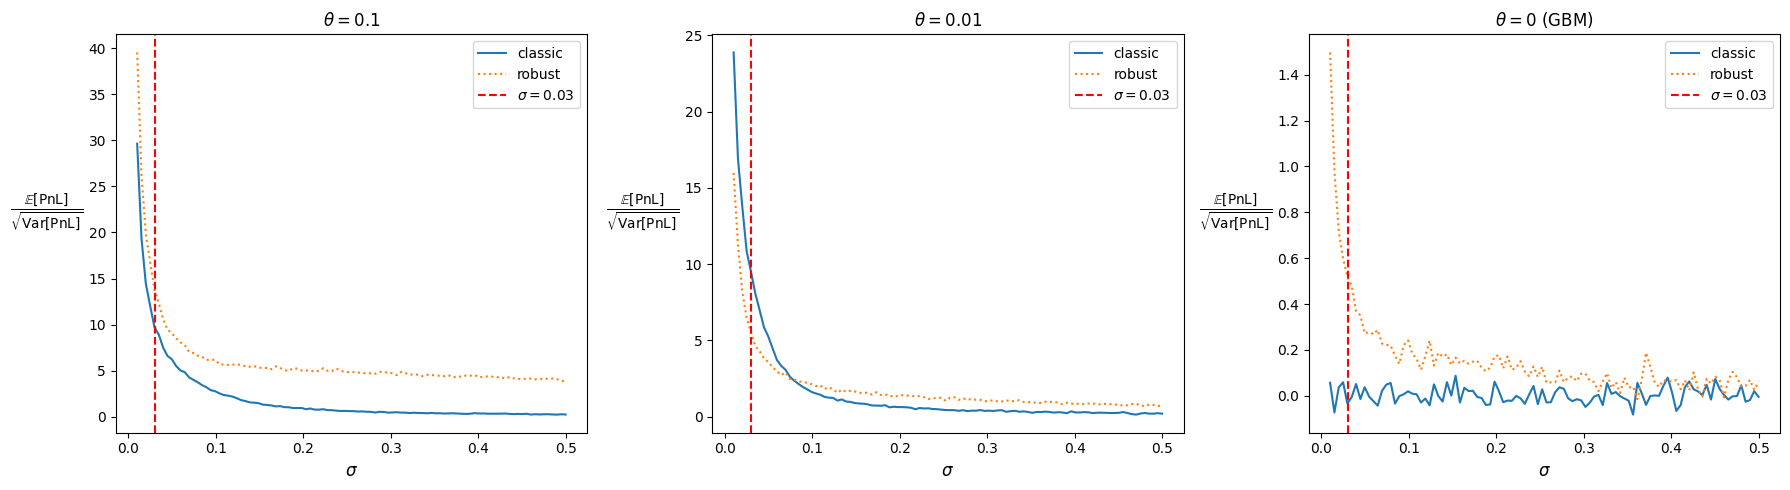

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: max theta 0.1
axs[0].plot(sigmas, perfs[:,-1], label='classic')
axs[0].plot(sigmas, robust_perfs[:,-1], label='robust', linestyle='dotted')
axs[0].axvline(x=0.03, color='red', linestyle='--', label=r'$\sigma = 0.03$')
axs[0].set_xlabel(r'$\sigma$', fontsize=12, rotation=0)
axs[0].set_ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$', fontsize=14, rotation=0, labelpad=30)
axs[0].legend()
axs[0].set_title(r'$\theta = 0.1$')

# Plot 2: theta = 0, i.e., GBM
axs[2].plot(sigmas, perfs[:,0], label='classic')
axs[2].plot(sigmas, robust_perfs[:,0], label='robust', linestyle='dotted')
axs[2].axvline(x=0.03, color='red', linestyle='--', label=r'$\sigma = 0.03$')
axs[2].set_xlabel(r'$\sigma$', fontsize=12, rotation=0)
axs[2].set_ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$', fontsize=14, rotation=0, labelpad=30)
axs[2].legend()
axs[2].set_title(r'$\theta = 0$ (GBM)')

# Plot 3: training theta 0.01
axs[1].plot(sigmas, perfs[:,10], label='classic')
axs[1].plot(sigmas, robust_perfs[:,10], label='robust', linestyle='dotted')
axs[1].axvline(x=0.03, color='red', linestyle='--', label=r'$\sigma = 0.03$')
axs[1].set_xlabel(r'$\sigma$', fontsize=12, rotation=0)
axs[1].set_ylabel(r'$\frac{\mathbb{E}[\text{PnL}]}{\sqrt{\text{Var}[\text{PnL}]}}$', fontsize=14, rotation=0, labelpad=30)
axs[1].legend()
axs[1].set_title(r'$\theta = 0.01$')


plt.tight_layout()
plt.savefig('sigmas_combined.png', dpi=300)
plt.show()
